# Phase 2 - BERT Baseline

### Goal of this notebook
*   Implement a baseline BERT model for **Sentiment Analysis** and **Sarcasm Detection**.
*   Train on specific data settings (Google, Reddit, National Varieties) and evaluate across multiple test sets.

### Dataset + Evaluation Protocol
*   **Dataset:** BESSTIE (Processed).
*   **Tasks:** Sentiment, Sarcasm.
*   **Varieties:** en-AU, en-IN, en-UK, en-US, etc.
*   **Sources:** Google Reviews, Reddit, Twitter.

### Notebook Steps
1.  **Setup:** Install libs, mount Drive, set configs & seed.
2.  **Data Loading:** Read index CSVs for train/test splits.
3.  **Model Prep:** Tokenizer, Dataset class, BERT Binary Classifier.
4.  **Training:** Loop through defined settings, train, save checkpoints.
5.  **Evaluation:** Predict on test sets, compute metrics (F1, Acc).
6.  **Analysis:** Generate Heatmaps, Bar Charts, and Error Analysis tables.

### Outputs
*   **Metrics:** `models/bert_baseline_ce/metrics/*.csv`
*   **Predictions:** `models/bert_baseline_ce/predictions/*.csv`
*   **Figures:** `models/bert_baseline_ce/figures/*.png`
*   **Checkpoints:** `models/bert_baseline_ce/checkpoints/*.pt`

### How to reproduce
*   **Seed:** 42
*   **Model:** `bert-base-cased`
*   **Config:** Modify the `CFG` dictionary in **Step 3** to change epochs, batch size, or model.

### Step 1 — Setup Environment
*   **Purpose:** Install required libraries and import dependencies.
*   **Main Inputs:** `requirements` (transformers, accelerate, datasets, scikit-learn).
*   **Main Outputs:** Environment ready for training.
*   **Assumptions:** Internet connection available for pip install.

In [ ]:
!pip -q install -U transformers accelerate datasets scikit-learn

import os, re, json, math, random, time
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import (
    AutoTokenizer,
    AutoModel,
    get_linear_schedule_with_warmup
)

from torch.optim import AdamW

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.2/515.2 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 116.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 20.0 MB/s eta 0:00:00


### Step 2 — Mount Drive
*   **Purpose:** Mount Google Drive to access data and save artifacts.
*   **Main Inputs:** User authentication.
*   **Main Outputs:** Drive mounted at `/content/drive`.
*   **Assumptions:** User has data in the expected Drive path.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Step 3 — Define Paths & Config
*   **Purpose:** Set up file paths and training configuration.
*   **Main Inputs:** `BASE` path.
*   **Main Outputs:** Directories created; `CFG` dict defined.
*   **Assumptions:** Base path `/content/drive/MyDrive/DNLP` exists.

In [ ]:
BASE = Path("/content/drive/MyDrive/DNLP")

PROC_DIR = BASE / "data" / "processed"
RUN_DIR  = BASE / "models" / "bert_baseline_ce"   # change if you want

CKPT_DIR = RUN_DIR / "checkpoints"
MET_DIR  = RUN_DIR / "metrics"
PRD_DIR  = RUN_DIR / "predictions"
FIG_DIR  = RUN_DIR / "figures"

for d in [CKPT_DIR, MET_DIR, PRD_DIR, FIG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

CFG = {
    "SEED": 42,
    "MODEL_NAME": "bert-base-cased",
    "MAX_LEN": 256,            # keep 256 for baseline speed; extension can use 512
    "BATCH_SIZE": 16,
    "LR": 2e-5,
    "WD": 0.01,
    "EPOCHS": 5,
    "PATIENCE": 2,
    "WARMUP_RATIO": 0.1,
    "GRAD_CLIP": 1.0,
    "USE_AMP": True,
    "NUM_WORKERS": 2,
}

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)
print("PROC_DIR:", PROC_DIR)
print("RUN_DIR :", RUN_DIR)

DEVICE: cuda
PROC_DIR: /content/drive/MyDrive/DNLP/data/processed
RUN_DIR : /content/drive/MyDrive/DNLP/models/bert_baseline_ce


### Step 4 — Seeding
*   **Purpose:** Ensure reproducibility.
*   **Main Inputs:** `CFG['SEED']`.
*   **Main Outputs:** Fixed seeds for Python, NumPy, and Torch.
*   **Assumptions:** Deterministic behavior desired.

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG["SEED"])

### Step 5 — Load Index Files
*   **Purpose:** Load master index CSVs for train/test settings.
*   **Main Inputs:** `index_settings.csv`, `index_testsets.csv`.
*   **Main Outputs:** DataFrames (`sent_settings`, `sarc_tests`, etc.).
*   **Assumptions:** Files exist in `PROC_DIR`.

In [ ]:
def load_index_settings(proc_dir: Path, task: str) -> pd.DataFrame:
    p = proc_dir / task / "index_settings.csv"
    if not p.exists():
        raise FileNotFoundError(f"Missing: {p}")
    df = pd.read_csv(p)
    # expected columns: train_setting, train_csv, val_csv, ...
    return df

def load_testsets_index(proc_dir: Path, task: str) -> pd.DataFrame:
    p = proc_dir / task / "testsets" / "index_testsets.csv"
    if not p.exists():
        raise FileNotFoundError(f"Missing: {p}")
    df = pd.read_csv(p)
    # expected columns: test_setting, test_csv, ...
    return df

sent_settings = load_index_settings(PROC_DIR, "sentiment")
sarc_settings = load_index_settings(PROC_DIR, "sarcasm")

sent_tests = load_testsets_index(PROC_DIR, "sentiment")
sarc_tests = load_testsets_index(PROC_DIR, "sarcasm")

print("Sentiment settings:", len(sent_settings), "| testsets:", len(sent_tests))
print("Sarcasm   settings:", len(sarc_settings), "| testsets:", len(sarc_tests))
display(sent_settings.head(5))
display(sent_tests.head(5))

Sentiment settings: 5 | testsets: 6
Sarcasm   settings: 4 | testsets: 5


,task,setting,train_csv,val_csv,splits_json,testsets_index_csv,n_train,n_val
0,sentiment,Google,/content/drive/MyDrive/DNLP/data/processed/sen...,/content/drive/MyDrive/DNLP/data/processed/sen...,/content/drive/MyDrive/DNLP/data/splits/sentim...,/content/drive/MyDrive/DNLP/data/processed/sen...,3529,882
1,sentiment,Reddit,/content/drive/MyDrive/DNLP/data/processed/sen...,/content/drive/MyDrive/DNLP/data/processed/sen...,/content/drive/MyDrive/DNLP/data/splits/sentim...,/content/drive/MyDrive/DNLP/data/processed/sen...,3564,891
2,sentiment,TRAIN_en-AU,/content/drive/MyDrive/DNLP/data/processed/sen...,/content/drive/MyDrive/DNLP/data/processed/sen...,/content/drive/MyDrive/DNLP/data/splits/sentim...,/content/drive/MyDrive/DNLP/data/processed/sen...,2167,542
3,sentiment,TRAIN_en-IN,/content/drive/MyDrive/DNLP/data/processed/sen...,/content/drive/MyDrive/DNLP/data/processed/sen...,/content/drive/MyDrive/DNLP/data/splits/sentim...,/content/drive/MyDrive/DNLP/data/processed/sen...,2667,666
4,sentiment,TRAIN_en-UK,/content/drive/MyDrive/DNLP/data/processed/sen...,/content/drive/MyDrive/DNLP/data/processed/sen...,/content/drive/MyDrive/DNLP/data/splits/sentim...,/content/drive/MyDrive/DNLP/data/processed/sen...,2259,565


,test_setting,csv,n,label_counts,variety_counts,source_counts
0,TEST_FULL,/content/drive/MyDrive/DNLP/data/processed/sen...,1212,"{0: 611, 1: 601}","{'en-IN': 455, 'en-UK': 386, 'en-AU': 371}","{'Reddit': 609, 'Google': 603}"
1,TEST_Google,/content/drive/MyDrive/DNLP/data/processed/sen...,603,"{1: 450, 0: 153}","{'en-UK': 248, 'en-IN': 225, 'en-AU': 130}",{'Google': 603}
2,TEST_Reddit,/content/drive/MyDrive/DNLP/data/processed/sen...,609,"{0: 458, 1: 151}","{'en-AU': 241, 'en-IN': 230, 'en-UK': 138}",{'Reddit': 609}
3,TEST_en-AU,/content/drive/MyDrive/DNLP/data/processed/sen...,371,"{0: 198, 1: 173}",{'en-AU': 371},"{'Reddit': 241, 'Google': 130}"
4,TEST_en-IN,/content/drive/MyDrive/DNLP/data/processed/sen...,455,"{0: 229, 1: 226}",{'en-IN': 455},"{'Reddit': 230, 'Google': 225}"


### Step 6 — Path Detection Logic
*   **Purpose:** Auto-detect the CSV path column in index files.
*   **Main Inputs:** Test index DataFrame.
*   **Main Outputs:** Detected column name (e.g., `'csv'`).
*   **Assumptions:** Column names may vary (legacy support).

In [ ]:
def _detect_path_col(df: pd.DataFrame, prefer_prefix="test"):
    cols = list(df.columns)

    # Most common candidates, in priority order
    preferred = [
        f"{prefer_prefix}_csv", f"{prefer_prefix}_path",
        "test_csv", "test_path", "csv_path", "path", "file", "filepath"
    ]
    for c in preferred:
        if c in cols:
            return c

    # fallback: any column that looks like it contains csv paths
    for c in cols:
        if df[c].astype(str).str.contains(r"\.csv$", case=False, na=False).any():
            return c

    raise KeyError(f"Couldn't detect a CSV path column in test index. Columns are: {cols}")

print("sarc_tests columns:", list(sarc_tests.columns))

path_col = _detect_path_col(sarc_tests, prefer_prefix="test")
print("Detected test CSV path column:", path_col)

tmp_path = sarc_tests.iloc[0][path_col]
print("Example test csv path:", tmp_path)

tmp = pd.read_csv(tmp_path)
if "source_name" in tmp.columns:
    print("Sarcasm sample sources:", tmp["source_name"].unique())
else:
    print("No source_name column found in the test CSV. Columns:", list(tmp.columns))

sarc_tests columns: ['test_setting', 'csv', 'n', 'label_counts', 'variety_counts', 'source_counts']
Detected test CSV path column: csv
Example test csv path: /content/drive/MyDrive/DNLP/data/processed/sarcasm/testsets/TEST_FULL.csv
Sarcasm sample sources: ['Reddit']


### Step 7 — Tokenizer
*   **Purpose:** Load the BERT tokenizer.
*   **Main Inputs:** `CFG['MODEL_NAME']`.
*   **Main Outputs:** `tokenizer` object.
*   **Assumptions:** Model available on HF Hub.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(CFG["MODEL_NAME"], use_fast=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

### Step 8 — Dataset Class
*   **Purpose:** Prepare data for PyTorch DataLoader.
*   **Main Inputs:** DataFrame, tokenizer.
*   **Main Outputs:** Encoded batch (`input_ids`, `attention_mask`, `y`).
*   **Assumptions:** Data has 'text' and 'label' columns.

In [ ]:
TEXT_COL   = "text"
LABEL_COL  = "label"
TASK_COL   = "task"
VAR_COL    = "variety_name"
SRC_COL    = "source_name"

class TextClsDataset(Dataset):
    def __init__(self, df: pd.DataFrame, max_len: int):
        self.df = df.reset_index(drop=True)
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        text = str(row[TEXT_COL])
        y = int(row[LABEL_COL])
        meta = {
            "variety_name": row.get(VAR_COL, ""),
            "source_name": row.get(SRC_COL, ""),
        }
        return text, y, meta

def collate_fn(batch):
    texts, ys, metas = zip(*batch)
    enc = tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        max_length=CFG["MAX_LEN"],
        return_tensors="pt"
    )
    y = torch.tensor(ys, dtype=torch.long)
    return enc, y, metas, list(texts)

### Step 9 — Model Architecture
*   **Purpose:** Define the BERT Classification model.
*   **Main Inputs:** `bert-base-cased`.
*   **Main Outputs:** Logits for binary classification.
*   **Assumptions:** Uses CLS token for classification.

In [ ]:
class BertBinary(nn.Module):
    def __init__(self, model_name: str):
        super().__init__()
        self.back = AutoModel.from_pretrained(model_name)
        hid = self.back.config.hidden_size
        self.drop = nn.Dropout(0.1)
        self.cls = nn.Linear(hid, 2)

    def forward(self, input_ids, attention_mask):
        out = self.back(input_ids=input_ids, attention_mask=attention_mask)
        x = out.last_hidden_state[:, 0, :]
        x = self.drop(x)
        logits = self.cls(x)
        return logits

### Step 10 — Metrics & Prediction
*   **Purpose:** Helper functions to calculate metrics and run inference.
*   **Main Inputs:** Model, DataLoader.
*   **Main Outputs:** Metrics dict (F1, Acc), Predictions DataFrame.
*   **Assumptions:** Threshold = 0.5.

In [ ]:
def compute_metrics(y_true, y_pred):
    return {
        "acc": float(accuracy_score(y_true, y_pred)),
        "macro_f1": float(f1_score(y_true, y_pred, average="macro")),
        "precision": float(precision_score(y_true, y_pred, average="binary", zero_division=0)),
        "recall": float(recall_score(y_true, y_pred, average="binary", zero_division=0)),
    }

@torch.no_grad()
def predict_df(model, loader):
    model.eval()
    rows = []
    for enc, y, metas, texts in loader:
        enc = {k: v.to(DEVICE) for k, v in enc.items()}
        logits = model(enc["input_ids"], enc["attention_mask"])
        prob = torch.softmax(logits, dim=-1)[:, 1].detach().cpu().numpy()
        pred = (prob >= 0.5).astype(int)
        y_np = y.numpy()

        for i in range(len(texts)):
            rows.append({
                "label": int(y_np[i]),
                "pred": int(pred[i]),
                "prob1": float(prob[i]),
                "variety_name": metas[i].get("variety_name", ""),
                "source_name": metas[i].get("source_name", ""),
                "text": texts[i],
            })
    return pd.DataFrame(rows)

### Step 11 — Training Loop
*   **Purpose:** Train one model for a specific setting.
*   **Main Inputs:** Task, setting name, CSV paths.
*   **Main Outputs:** Saved model checkpoint (`.pt`).
*   **Assumptions:** Weighted CrossEntropyLoss.

In [ ]:
def train_one_setting(task: str, train_setting: str, train_csv: str, val_csv: str,
                      lr=2e-5, wd=0.01, epochs=5, patience=2,
                      warmup_ratio=0.1, grad_clip=1.0, use_amp=True):

    # Define path once (variant is hardcoded to 'ce' here)
    ckpt_path = os.path.join(CKPT_DIR, f"{task}_{train_setting}_ce.pt")

    df_tr = pd.read_csv(train_csv)
    df_va = pd.read_csv(val_csv)

    tr_ds = TextClsDataset(df_tr, CFG["MAX_LEN"])
    va_ds = TextClsDataset(df_va, CFG["MAX_LEN"])

    tr_ld = DataLoader(tr_ds, batch_size=CFG["BATCH_SIZE"], shuffle=True,
                       num_workers=CFG["NUM_WORKERS"], collate_fn=collate_fn)
    va_ld = DataLoader(va_ds, batch_size=CFG["BATCH_SIZE"], shuffle=False,
                       num_workers=CFG["NUM_WORKERS"], collate_fn=collate_fn)

    model = BertBinary(CFG["MODEL_NAME"]).to(DEVICE)

    # class weights from train only
    y_tr = df_tr[LABEL_COL].values
    counts = np.bincount(y_tr, minlength=2).astype(np.float32)
    w = (counts.sum() / np.maximum(counts, 1.0))
    w = w / w.sum() * 2.0
    w_t = torch.tensor(w, dtype=torch.float32, device=DEVICE)

    crit = nn.CrossEntropyLoss(weight=w_t)
    opt = AdamW(model.parameters(), lr=lr, weight_decay=wd)

    total_steps = epochs * len(tr_ld)
    warmup_steps = int(total_steps * warmup_ratio)
    sch = get_linear_schedule_with_warmup(opt, warmup_steps, total_steps)

    scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and DEVICE=="cuda"))

    best_f1 = -1
    best_state = None
    bad = 0

    for ep in range(1, epochs+1):
        model.train()
        losses = []
        for enc, y, metas, texts in tr_ld:
            enc = {k: v.to(DEVICE) for k, v in enc.items()}
            y = y.to(DEVICE)

            opt.zero_grad(set_to_none=True)
            with torch.amp.autocast(device_type="cuda", enabled=(use_amp and DEVICE=="cuda")):
                logits = model(enc["input_ids"], enc["attention_mask"])
                loss = crit(logits, y)

            scaler.scale(loss).backward()
            scaler.unscale_(opt)
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            scaler.step(opt)
            scaler.update()
            sch.step()
            losses.append(loss.item())

        # val
        dfp = predict_df(model, va_ld)
        met = compute_metrics(dfp["label"].values, dfp["pred"].values)
        print(f"[{task} | {train_setting}] EP{ep} loss={np.mean(losses):.4f} val_macro_f1={met['macro_f1']:.4f}")

        if met["macro_f1"] > best_f1:
            best_f1 = met["macro_f1"]
            bad = 0
            # Save best state to memory (CPU) to persist it
            best_state = {k: v.clone().cpu() for k, v in model.state_dict().items()}
        else:
            bad += 1
            if bad >= patience:
                print("Early stopping.")
                break

    # after training loop ends (no matter how it ends)
    assert best_state is not None, "best_state was never set (did training fail?)"
    torch.save(best_state, ckpt_path)
    print("✅ Saved:", ckpt_path)

    return str(ckpt_path)

### Step 12 — Evaluation Routine
*   **Purpose:** Evaluate trained models on test sets.
*   **Main Inputs:** Model checkpoint, test index.
*   **Main Outputs:** Metrics DF, Predictions DF.
*   **Assumptions:** Generates per-variety breakdowns.

In [ ]:
def eval_on_testsets(task: str, train_setting: str, ckpt_path: str, test_index: pd.DataFrame):
    model = BertBinary(CFG["MODEL_NAME"]).to(DEVICE)
    model.load_state_dict(torch.load(ckpt_path, map_location=DEVICE))
    model.eval()

    all_metrics = []
    all_preds = []

    for _, row in test_index.iterrows():
        test_setting = row["test_setting"]
        test_csv = row["test_csv"]

        df_te = pd.read_csv(test_csv)
        te_ds = TextClsDataset(df_te, CFG["MAX_LEN"])
        te_ld = DataLoader(te_ds, batch_size=CFG["BATCH_SIZE"], shuffle=False,
                           num_workers=CFG["NUM_WORKERS"], collate_fn=collate_fn)

        dfp = predict_df(model, te_ld)
        met = compute_metrics(dfp["label"].values, dfp["pred"].values)

        met_row = {
            "task": task,
            "train_setting": train_setting,
            "variant": "ce",
            "test_setting": test_setting,
            "split": "test",
            "n": int(len(dfp)),
            **met
        }
        all_metrics.append(met_row)

        # add metadata for saving
        dfp.insert(0, "task", task)
        dfp.insert(1, "variant", "ce")
        dfp.insert(2, "train_setting", train_setting)
        dfp.insert(3, "test_setting", test_setting)

        all_preds.append(dfp)

        # per-variety breakdown for TEST_* (especially cross-variety)
        if "variety_name" in dfp.columns:
            pv = []
            for g, dfg in dfp.groupby("variety_name"):
                m = compute_metrics(dfg["label"].values, dfg["pred"].values)
                pv.append({
                    "task": task,
                    "train_setting": train_setting,
                    "variant": "ce",
                    "test_setting": test_setting,
                    "group": g,
                    "n": int(len(dfg)),
                    **m
                })
            pv = pd.DataFrame(pv)
            pv_path = MET_DIR / f"pervar_{task}_{train_setting}_{test_setting}_ce.csv"
            pv.to_csv(pv_path, index=False)

    met_df = pd.DataFrame(all_metrics)
    pred_df = pd.concat(all_preds, ignore_index=True)

    return met_df, pred_df

### Step 13 — Main Execution (Run Task)
*   **Purpose:** Orchestrate training and evaluation.
*   **Main Inputs:** Task name, Settings DF, Test DF.
*   **Main Outputs:** Consolidated results CSVs.
*   **Assumptions:** Runs sequentially.

In [ ]:
def run_task(task: str, settings_df: pd.DataFrame, test_df: pd.DataFrame, limit_settings=None):
    # Pre-process DataFrames to match expected column names
    # Settings: expect 'train_setting', have 'setting'
    if "train_setting" not in settings_df.columns and "setting" in settings_df.columns:
        settings_df = settings_df.rename(columns={"setting": "train_setting"})

    # Tests: expect 'test_csv', have 'csv'
    if "test_csv" not in test_df.columns and "csv" in test_df.columns:
        test_df = test_df.rename(columns={"csv": "test_csv"})

    # Optionally limit which settings to run (smoke test)
    df = settings_df.copy()
    if limit_settings is not None:
        df = df[df["train_setting"].isin(limit_settings)].copy()

    all_met = []
    all_pred = []

    print(f"\n=== RUN TASK: {task} | settings: {len(df)} | testsets: {len(test_df)} ===")

    for _, r in df.iterrows():
        train_setting = r["train_setting"]
        train_csv = r["train_csv"]
        val_csv = r["val_csv"]

        ckpt = train_one_setting(
            task=task,
            train_setting=train_setting,
            train_csv=train_csv,
            val_csv=val_csv,
            lr=CFG["LR"], wd=CFG["WD"], epochs=CFG["EPOCHS"], patience=CFG["PATIENCE"],
            warmup_ratio=CFG["WARMUP_RATIO"], grad_clip=CFG["GRAD_CLIP"], use_amp=CFG["USE_AMP"]
        )

        # Handle Drive sync latency
        if not os.path.exists(ckpt):
            print(f"Waiting for checkpoint sync: {ckpt}")
            time.sleep(3)

        if not os.path.exists(ckpt):
            print(f"Warning: Checkpoint still not found: {ckpt}. Skipping evaluation.")
            continue

        met_df, pred_df = eval_on_testsets(task, train_setting, ckpt, test_df)

        # save per-setting predictions
        pred_path = PRD_DIR / f"{task}_{train_setting}_ce_preds.csv"
        pred_df.to_csv(pred_path, index=False)

        all_met.append(met_df)
        all_pred.append(pred_df)

    if len(all_met) == 0:
        return pd.DataFrame(), pd.DataFrame()

    all_met = pd.concat(all_met, ignore_index=True)
    all_pred = pd.concat(all_pred, ignore_index=True)
    return all_met, all_pred


# Sarcasm is Reddit-only protocol; your preprocess already ensures that settings/testsets reflect that. :contentReference[oaicite:2]{index=2}
sent_met, sent_pred = run_task("sentiment", sent_settings, sent_tests, limit_settings=None)
sarc_met, sarc_pred = run_task("sarcasm", sarc_settings, sarc_tests, limit_settings=None)

metrics_all = pd.concat([sent_met, sarc_met], ignore_index=True) if len(sent_met)+len(sarc_met) else pd.DataFrame()
preds_all   = pd.concat([sent_pred, sarc_pred], ignore_index=True) if len(sent_pred)+len(sarc_pred) else pd.DataFrame()

metrics_path = MET_DIR / "bert_ce_metrics_all.csv"
preds_path   = PRD_DIR / "bert_ce_predictions_all.csv"

metrics_all.to_csv(metrics_path, index=False)
preds_all.to_csv(preds_path, index=False)

print("Saved:", metrics_path)
print("Saved:", preds_path)
display(metrics_all.head(20))


=== RUN TASK: sentiment | settings: 5 | testsets: 6 ===


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-cased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
/tmp/ipython-input-1989575844.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and DEVICE=="cuda"))


[sentiment | Google] EP1 loss=0.4304 val_macro_f1=0.8836
[sentiment | Google] EP2 loss=0.2287 val_macro_f1=0.8899
[sentiment | Google] EP3 loss=0.1183 val_macro_f1=0.8893
[sentiment | Google] EP4 loss=0.0476 val_macro_f1=0.8970
[sentiment | Google] EP5 loss=0.0225 val_macro_f1=0.8996
✅ Saved: /content/drive/MyDrive/DNLP/models/bert_baseline_ce/checkpoints/sentiment_Google_ce.pt


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-cased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-cased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
/tmp/ipython-input-1989575844.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and DEVICE=="cuda"))


[sentiment | Reddit] EP1 loss=0.5331 val_macro_f1=0.7984
[sentiment | Reddit] EP2 loss=0.2929 val_macro_f1=0.7756
[sentiment | Reddit] EP3 loss=0.1436 val_macro_f1=0.8118
[sentiment | Reddit] EP4 loss=0.0463 val_macro_f1=0.8163
[sentiment | Reddit] EP5 loss=0.0117 val_macro_f1=0.8143
✅ Saved: /content/drive/MyDrive/DNLP/models/bert_baseline_ce/checkpoints/sentiment_Reddit_ce.pt


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-cased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-cased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
/tmp/ipython-input-1989575844.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and DEVICE=="cuda"))


[sentiment | TRAIN_en-AU] EP1 loss=0.4854 val_macro_f1=0.8829
[sentiment | TRAIN_en-AU] EP2 loss=0.2102 val_macro_f1=0.8757
[sentiment | TRAIN_en-AU] EP3 loss=0.0842 val_macro_f1=0.8927
[sentiment | TRAIN_en-AU] EP4 loss=0.0230 val_macro_f1=0.8861
[sentiment | TRAIN_en-AU] EP5 loss=0.0072 val_macro_f1=0.8827
Early stopping.
✅ Saved: /content/drive/MyDrive/DNLP/models/bert_baseline_ce/checkpoints/sentiment_TRAIN_en-AU_ce.pt


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-cased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-cased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
/tmp/ipython-input-1989575844.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and DEVICE=="cuda"))


[sentiment | TRAIN_en-IN] EP1 loss=0.4916 val_macro_f1=0.8340
[sentiment | TRAIN_en-IN] EP2 loss=0.2910 val_macro_f1=0.8421
[sentiment | TRAIN_en-IN] EP3 loss=0.1384 val_macro_f1=0.8288
[sentiment | TRAIN_en-IN] EP4 loss=0.0511 val_macro_f1=0.8183
Early stopping.
✅ Saved: /content/drive/MyDrive/DNLP/models/bert_baseline_ce/checkpoints/sentiment_TRAIN_en-IN_ce.pt


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-cased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-cased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
/tmp/ipython-input-1989575844.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and DEVICE=="cuda"))


[sentiment | TRAIN_en-UK] EP1 loss=0.3587 val_macro_f1=0.9344
[sentiment | TRAIN_en-UK] EP2 loss=0.1267 val_macro_f1=0.9451
[sentiment | TRAIN_en-UK] EP3 loss=0.0458 val_macro_f1=0.9398
[sentiment | TRAIN_en-UK] EP4 loss=0.0153 val_macro_f1=0.9433
Early stopping.
✅ Saved: /content/drive/MyDrive/DNLP/models/bert_baseline_ce/checkpoints/sentiment_TRAIN_en-UK_ce.pt


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-cased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



=== RUN TASK: sarcasm | settings: 4 | testsets: 5 ===


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-cased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
/tmp/ipython-input-1989575844.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and DEVICE=="cuda"))


[sarcasm | FULL] EP1 loss=0.6895 val_macro_f1=0.6300
[sarcasm | FULL] EP2 loss=0.5266 val_macro_f1=0.6494
[sarcasm | FULL] EP3 loss=0.2695 val_macro_f1=0.5589
[sarcasm | FULL] EP4 loss=0.1097 val_macro_f1=0.6284
Early stopping.
✅ Saved: /content/drive/MyDrive/DNLP/models/bert_baseline_ce/checkpoints/sarcasm_FULL_ce.pt


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-cased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-cased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
/tmp/ipython-input-1989575844.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and DEVICE=="cuda"))


[sarcasm | TRAIN_en-AU] EP1 loss=0.6817 val_macro_f1=0.6420
[sarcasm | TRAIN_en-AU] EP2 loss=0.4707 val_macro_f1=0.6584
[sarcasm | TRAIN_en-AU] EP3 loss=0.2407 val_macro_f1=0.6445
[sarcasm | TRAIN_en-AU] EP4 loss=0.0879 val_macro_f1=0.6716
[sarcasm | TRAIN_en-AU] EP5 loss=0.0328 val_macro_f1=0.6620
✅ Saved: /content/drive/MyDrive/DNLP/models/bert_baseline_ce/checkpoints/sarcasm_TRAIN_en-AU_ce.pt


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-cased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-cased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
/tmp/ipython-input-1989575844.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and DEVICE=="cuda"))


[sarcasm | TRAIN_en-IN] EP1 loss=0.6976 val_macro_f1=0.5693
[sarcasm | TRAIN_en-IN] EP2 loss=0.5545 val_macro_f1=0.5693
[sarcasm | TRAIN_en-IN] EP3 loss=0.4334 val_macro_f1=0.5982
[sarcasm | TRAIN_en-IN] EP4 loss=0.2688 val_macro_f1=0.5797
[sarcasm | TRAIN_en-IN] EP5 loss=0.2135 val_macro_f1=0.5580
Early stopping.
✅ Saved: /content/drive/MyDrive/DNLP/models/bert_baseline_ce/checkpoints/sarcasm_TRAIN_en-IN_ce.pt


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-cased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-cased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
/tmp/ipython-input-1989575844.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and DEVICE=="cuda"))


[sarcasm | TRAIN_en-UK] EP1 loss=0.6821 val_macro_f1=0.6665
[sarcasm | TRAIN_en-UK] EP2 loss=0.5344 val_macro_f1=0.6105
[sarcasm | TRAIN_en-UK] EP3 loss=0.3024 val_macro_f1=0.6743
[sarcasm | TRAIN_en-UK] EP4 loss=0.1239 val_macro_f1=0.6821
[sarcasm | TRAIN_en-UK] EP5 loss=0.0651 val_macro_f1=0.6544
✅ Saved: /content/drive/MyDrive/DNLP/models/bert_baseline_ce/checkpoints/sarcasm_TRAIN_en-UK_ce.pt


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-cased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Saved: /content/drive/MyDrive/DNLP/models/bert_baseline_ce/metrics/roberta_ce_metrics_all.csv
Saved: /content/drive/MyDrive/DNLP/models/bert_baseline_ce/predictions/roberta_ce_predictions_all.csv


,task,train_setting,variant,test_setting,split,n,acc,macro_f1,precision,recall
0,sentiment,Google,ce,TEST_FULL,test,1212,0.872112,0.872105,0.870432,0.871880
1,sentiment,Google,ce,TEST_Google,test,603,0.922056,0.893561,0.933333,0.964444
2,sentiment,Google,ce,TEST_Reddit,test,609,0.822660,0.754435,0.656934,0.596026
3,sentiment,Google,ce,TEST_en-AU,test,371,0.876011,0.874478,0.904459,0.820809
4,sentiment,Google,ce,TEST_en-IN,test,455,0.810989,0.810915,0.794118,0.836283
5,sentiment,Google,ce,TEST_en-UK,test,386,0.940415,0.940202,0.932367,0.955446
6,sentiment,Reddit,ce,TEST_FULL,test,1212,0.859736,0.859567,0.830015,0.901830
7,sentiment,Reddit,ce,TEST_Google,test,603,0.864013,0.793113,0.863636,0.971111
8,sentiment,Reddit,ce,TEST_Reddit,test,609,0.855501,0.804523,0.714286,0.695364
9,sentiment,Reddit,ce,TEST_en-AU,test,371,0.870620,0.870408,0.841530,0.890173


### Step 14 — Visualization (Heatmaps)
*   **Purpose:** Plot Macro-F1 heatmaps.
*   **Main Inputs:** `metrics_all`.
*   **Main Outputs:** Saved PNGs.
*   **Assumptions:** Visualizes Train Setting vs Test Setting performance.

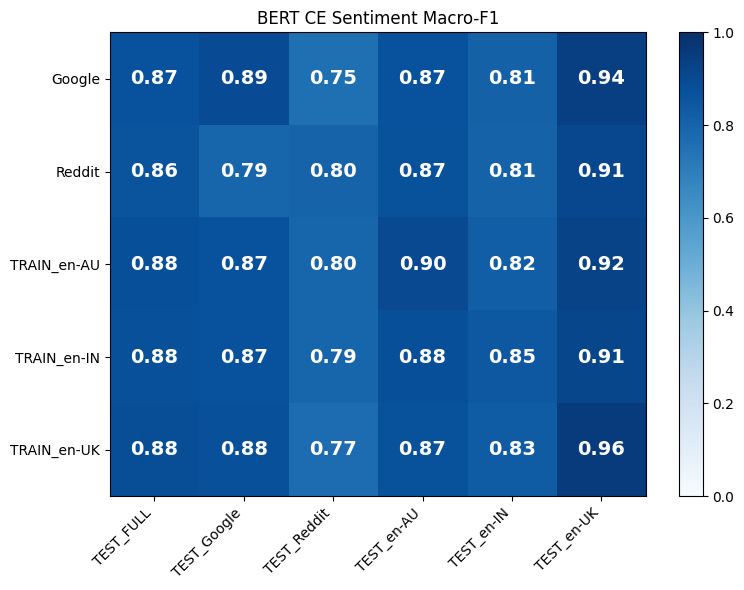

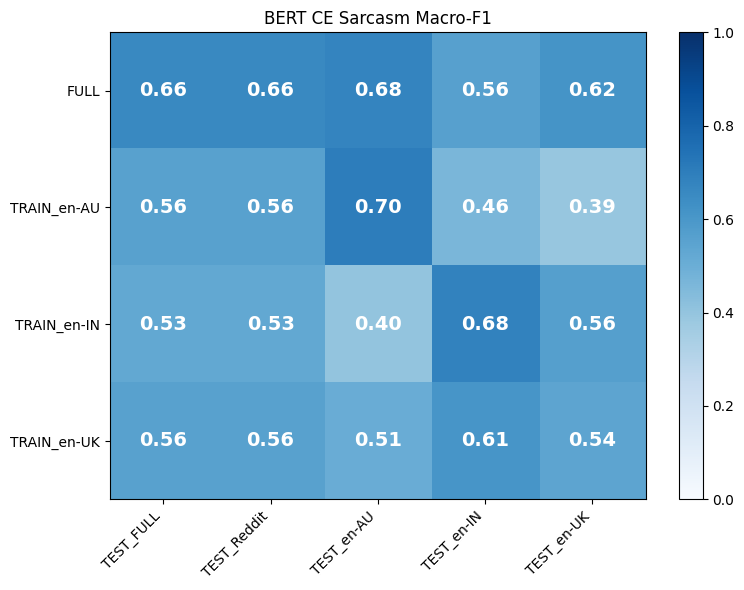

In [ ]:
def heatmap_macro_f1(df: pd.DataFrame, task: str, title: str, out_png: Path):
    sub = df[df["task"] == task].copy()
    if sub.empty:
        print("No rows for", task)
        return
    pivot = sub.pivot_table(index="train_setting", columns="test_setting", values="macro_f1", aggfunc="mean")
    plt.figure(figsize=(8, 6))
    plt.imshow(pivot.values, aspect="auto", cmap="Blues", vmin=0, vmax=1)

    # Add text annotations
    for i in range(len(pivot.index)):
        for j in range(len(pivot.columns)):
            val = pivot.values[i, j]
            if not np.isnan(val):
                color = "white"
                plt.text(j, i, f"{val:.2f}", ha="center", va="center", color=color, fontsize=14, weight="bold")

    plt.xticks(range(pivot.shape[1]), pivot.columns, rotation=45, ha="right")
    plt.yticks(range(pivot.shape[0]), pivot.index)
    plt.colorbar()
    plt.title(title)
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.show()

heatmap_macro_f1(metrics_all, "sentiment", "BERT CE Sentiment Macro-F1", FIG_DIR/"heat_sentiment_ce.png")
heatmap_macro_f1(metrics_all, "sarcasm",   "BERT CE Sarcasm Macro-F1",   FIG_DIR/"heat_sarcasm_ce.png")

### Step 15 — Visualization (Bar Charts)
*   **Purpose:** Aggregate and plot results by evaluation type (Domain, Variety).
*   **Main Inputs:** `metrics_all`.
*   **Main Outputs:** Bar charts saved as PNGs.
*   **Assumptions:** Logic defines `eval_type` grouping.

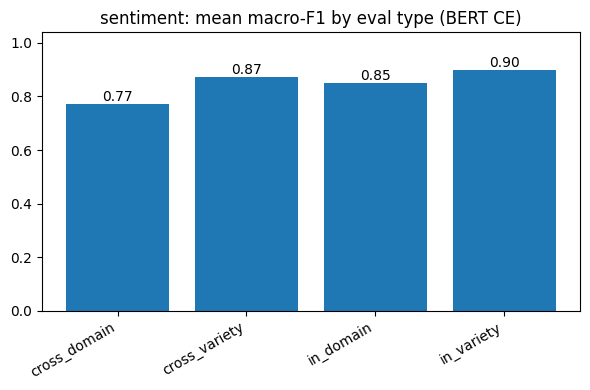

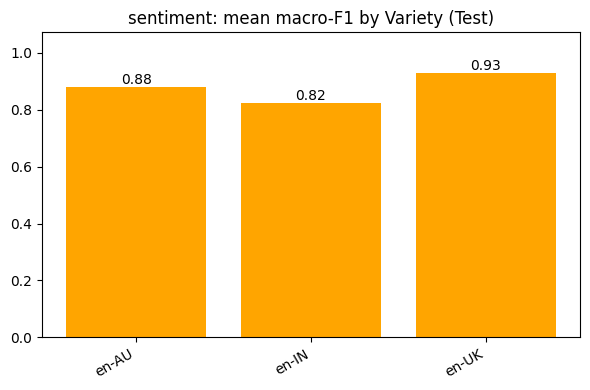

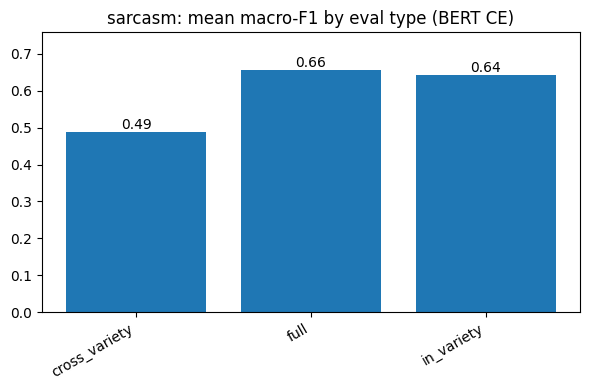

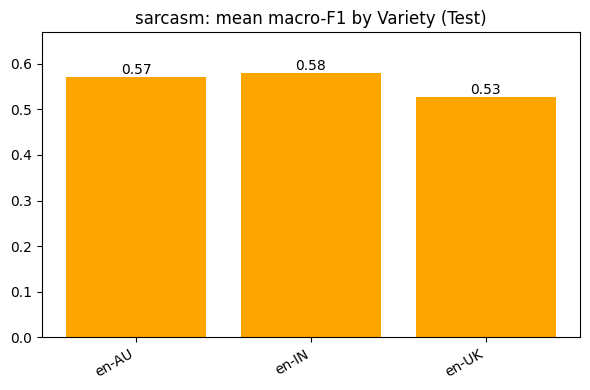

In [ ]:
def add_domain_flag(df):
    df = df.copy()
    def flag(row):
        tr = str(row["train_setting"])
        te = str(row["test_setting"])
        # domain
        if tr in ["Google","Reddit"] and te == f"TEST_{tr}":
            return "in_domain"
        if tr in ["Google","Reddit"] and te.startswith("TEST_") and te in ["TEST_Google","TEST_Reddit"] and te != f"TEST_{tr}":
            return "cross_domain"
        # variety
        if tr.startswith("TRAIN_") and te == ("TEST_" + tr.replace("TRAIN_","")):
            return "in_variety"
        if tr.startswith("TRAIN_") and te.startswith("TEST_en-") and te != ("TEST_" + tr.replace("TRAIN_","")):
            return "cross_variety"
        # full
        if tr == "FULL" and te == "TEST_FULL":
            return "full"
        return "other"
    df["eval_type"] = df.apply(flag, axis=1)
    return df

m2 = add_domain_flag(metrics_all)
sub = m2[m2["eval_type"].isin(["in_domain","cross_domain","in_variety","cross_variety","full"])].copy()

def plot_bar_with_values(x, y, title, filename, color=None):
    plt.figure(figsize=(6,4))
    bars = plt.bar(x, y, color=color)
    plt.title(title)
    plt.xticks(rotation=30, ha="right")

    # Add some headroom for labels
    y_min, y_max = plt.ylim()
    plt.ylim(y_min, y_max * 1.1)

    # Add values
    for rect in bars:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, f'{height:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(filename, dpi=200)
    plt.show()

for task in ["sentiment","sarcasm"]:
    # 1. Existing Eval Type Chart
    d = sub[sub["task"]==task].copy()
    if not d.empty:
        grp = d.groupby("eval_type")["macro_f1"].mean().reset_index()
        plot_bar_with_values(grp["eval_type"], grp["macro_f1"],
                             f"{task}: mean macro-F1 by eval type (BERT CE)",
                             FIG_DIR/f"bar_{task}_evaltype_ce.png")

    # 2. New Per-Variety Chart (Test Performance)
    # Filter for national varieties (e.g. TEST_en-AU, TEST_en-IN...)
    d_var = m2[(m2["task"]==task) & (m2["test_setting"].str.startswith("TEST_en-"))].copy()
    if not d_var.empty:
        d_var["variety"] = d_var["test_setting"].str.replace("TEST_", "")
        grp_var = d_var.groupby("variety")["macro_f1"].mean().reset_index()
        plot_bar_with_values(grp_var["variety"], grp_var["macro_f1"],
                             f"{task}: mean macro-F1 by Variety (Test)",
                             FIG_DIR/f"bar_{task}_variety_ce.png",
                             color="orange")

### Step 16 — Error Analysis
*   **Purpose:** Identify high-confidence failures.
*   **Main Inputs:** Predictions DataFrame.
*   **Main Outputs:** CSVs of top errors.
*   **Assumptions:** Top 15 sorted by confidence.

In [ ]:
# This produces examples you can cite in report even before extensions.
def top_mistakes(preds_all: pd.DataFrame, task: str, test_setting: str, k=15):
    df = preds_all[(preds_all["task"]==task) & (preds_all["test_setting"]==test_setting)].copy()
    if df.empty:
        return pd.DataFrame()
    df["wrong"] = (df["label"] != df["pred"]).astype(int)
    # "high confidence wrong": predicted prob far from 0.5
    df["conf"] = (df["prob1"] - 0.5).abs()
    out = df[df["wrong"]==1].sort_values("conf", ascending=False).head(k)
    return out[["text","label","pred","prob1","variety_name","source_name","train_setting","test_setting"]].copy()

ea_sent = top_mistakes(preds_all, "sentiment", "TEST_FULL", k=15)
ea_sarc = top_mistakes(preds_all, "sarcasm", "TEST_FULL", k=15)

ea_sent_path = MET_DIR / "error_analysis_sentiment_ce_top15.csv"
ea_sarc_path = MET_DIR / "error_analysis_sarcasm_ce_top15.csv"

ea_sent.to_csv(ea_sent_path, index=False)
ea_sarc.to_csv(ea_sarc_path, index=False)

print("Saved:", ea_sent_path)
print("Saved:", ea_sarc_path)
display(ea_sent.head(15))
display(ea_sarc.head(15))

Saved: /content/drive/MyDrive/DNLP/models/bert_baseline_ce/metrics/error_analysis_sentiment_ce_top15.csv
Saved: /content/drive/MyDrive/DNLP/models/bert_baseline_ce/metrics/error_analysis_sarcasm_ce_top15.csv


,text,label,pred,prob1,variety_name,source_name,train_setting,test_setting
4276,SRK is looking like johhny depp,1,0,0.000042,en-IN,Reddit,Reddit,TEST_FULL
4066,Nice place to spend quality time with family o...,0,1,0.999957,en-IN,Google,Reddit,TEST_FULL
4412,Foreigners should not be involved in protests....,1,0,0.000048,en-IN,Reddit,Reddit,TEST_FULL
4070,The food we ordered for dinner was normal jeer...,0,1,0.999951,en-IN,Google,Reddit,TEST_FULL
4094,Budget friendly hotel. The cleanliness is basi...,0,1,0.999950,en-IN,Google,Reddit,TEST_FULL
3726,An all day cafe with a fully licensed bar. See...,0,1,0.999947,en-AU,Google,Reddit,TEST_FULL
3659,"Ordered first time ever, takeaway delivered wh...",0,1,0.999946,en-AU,Google,Reddit,TEST_FULL
4039,I am very frequent buyer to this BIB since 8 Y...,0,1,0.999943,en-IN,Google,Reddit,TEST_FULL
452,The restaurant is only just beautiful to look ...,1,0,0.000058,en-IN,Google,Google,TEST_FULL
4703,Speed of service is average. Ordered food on t...,0,1,0.999941,en-UK,Google,Reddit,TEST_FULL


,text,label,pred,prob1,variety_name,source_name,train_setting,test_setting
20449,"So if ravana was an rss/bjp then if we apply ""...",0,1,0.999743,en-IN,Reddit,TRAIN_en-AU,TEST_FULL
20156,yeah been a long time since i've even bothered...,1,0,0.000269,en-AU,Reddit,TRAIN_en-AU,TEST_FULL
20506,Due to price fish and chips is now expensive.,1,0,0.000351,en-UK,Reddit,TRAIN_en-AU,TEST_FULL
20526,How thick do you have to be to believe in and ...,0,1,0.999645,en-UK,Reddit,TRAIN_en-AU,TEST_FULL
20530,"Unfortunately this is not the ""ITV rigged the ...",0,1,0.999621,en-UK,Reddit,TRAIN_en-AU,TEST_FULL
20338,What is this joke?\nThis guy killed two people...,0,1,0.999620,en-IN,Reddit,TRAIN_en-AU,TEST_FULL
20570,You do realise it was all me right?\nYes I bro...,0,1,0.999604,en-UK,Reddit,TRAIN_en-AU,TEST_FULL
20573,"Nasty people, best avoided when possible. It m...",0,1,0.999577,en-UK,Reddit,TRAIN_en-AU,TEST_FULL
20339,Congress has become B team of AAP. Congress le...,0,1,0.999531,en-IN,Reddit,TRAIN_en-AU,TEST_FULL
20495,The mental gymnastics some people are performi...,0,1,0.999515,en-UK,Reddit,TRAIN_en-AU,TEST_FULL
